Будем использовать данные из [соревнования HSE](https://www.kaggle.com/c/hse19-gbm/data). 


Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

Произведем первоначальную настройку данных:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('application_train.csv')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247330,0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,425716,1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,331625,0,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,455397,0,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,449114,0,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
train.shape

(215257, 122)

In [4]:
y = train['TARGET']
X = train.drop(['TARGET', 'SK_ID_CURR'], axis=1)

In [5]:
list(X.dtypes)

[dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('

In [6]:
list(X.columns)

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 

Видим, что, как минимум (первое бросившееся в глаза), FLAG_DOCUMENT_<> типа float64, хотя принимает 0 и 1 (по сути, тип bool, а не float64) - лучше отнести такое тоже к категориальным признакам. Также отнесем к категориальным признакам такие столбцы, в которым малое число уникальных значений:

In [7]:
categorical_str = np.array(  X.select_dtypes(include=['object']).columns.tolist()  )
categorical_str

array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'], dtype='<U26')

In [8]:
categorical_int = np.intersect1d(
                                np.array(  X.select_dtypes(include=['float', 'int']).columns.tolist()  ), 
                                np.array(  X.columns[X.nunique() < 7].tolist()  )
                            )
categorical_int

array(['AMT_REQ_CREDIT_BUREAU_HOUR', 'FLAG_CONT_MOBILE',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL',
       'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE',
       'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION'],
      dtype='<U28')

In [9]:
categorical = np.concatenate([categorical_str, categorical_int])

In [10]:
numerical = np.setdiff1d(  
                        np.array(X.columns.tolist()), 
                        categorical
                    )
numerical

array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'APARTMENTS_AVG', 'APARTMENTS_MEDI',
       'APARTMENTS_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI',
       'BASEMENTAREA_MODE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE',
       'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLOORSMAX_AVG',
       'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'FLOORSMIN_AVG',
       'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'HOUR_APPR_PROCESS_START',
       'LANDAREA_AVG', 'LANDARE

Пропуски заполним медианными значениями:

In [11]:
X['ELEVATORS_MODE'].head(10)

0       NaN
1       NaN
2    0.7250
3    0.0000
4       NaN
5    0.1611
6    0.3625
7    0.0000
8       NaN
9       NaN
Name: ELEVATORS_MODE, dtype: float64

In [12]:
X[numerical] = X[numerical].fillna(  X[numerical].median()  )
X['ELEVATORS_MODE'].head(10)

0    0.0000
1    0.0000
2    0.7250
3    0.0000
4    0.0000
5    0.1611
6    0.3625
7    0.0000
8    0.0000
9    0.0000
Name: ELEVATORS_MODE, dtype: float64

In [13]:
X[categorical_str] = X[categorical_str].fillna('NaN')
X[categorical_int] = X[categorical_int].fillna(X[categorical_int].min()-1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

---

Обучим реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров:

In [15]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.metrics import precision_recall_curve, auc

In [16]:
model = CatBoostClassifier()
model.fit(X_train[numerical], y_train)

Learning rate set to 0.087693
0:	learn: 0.6049769	total: 120ms	remaining: 1m 59s
1:	learn: 0.5361964	total: 161ms	remaining: 1m 20s
2:	learn: 0.4821567	total: 215ms	remaining: 1m 11s
3:	learn: 0.4390545	total: 260ms	remaining: 1m 4s
4:	learn: 0.4018378	total: 306ms	remaining: 1m
5:	learn: 0.3739330	total: 347ms	remaining: 57.5s
6:	learn: 0.3526696	total: 404ms	remaining: 57.3s
7:	learn: 0.3343885	total: 469ms	remaining: 58.1s
8:	learn: 0.3220711	total: 532ms	remaining: 58.6s
9:	learn: 0.3105392	total: 577ms	remaining: 57.1s
10:	learn: 0.3022429	total: 616ms	remaining: 55.4s
11:	learn: 0.2954793	total: 659ms	remaining: 54.3s
12:	learn: 0.2886762	total: 712ms	remaining: 54.1s
13:	learn: 0.2834892	total: 754ms	remaining: 53.1s
14:	learn: 0.2788217	total: 799ms	remaining: 52.5s
15:	learn: 0.2753479	total: 841ms	remaining: 51.7s
16:	learn: 0.2723116	total: 884ms	remaining: 51.1s
17:	learn: 0.2698230	total: 941ms	remaining: 51.3s
18:	learn: 0.2676872	total: 1.01s	remaining: 52s
19:	learn: 0.

160:	learn: 0.2450916	total: 9.43s	remaining: 49.2s
161:	learn: 0.2450356	total: 9.49s	remaining: 49.1s
162:	learn: 0.2449573	total: 9.54s	remaining: 49s
163:	learn: 0.2448931	total: 9.59s	remaining: 48.9s
164:	learn: 0.2448498	total: 9.63s	remaining: 48.7s
165:	learn: 0.2447834	total: 9.68s	remaining: 48.6s
166:	learn: 0.2447378	total: 9.73s	remaining: 48.5s
167:	learn: 0.2446605	total: 9.78s	remaining: 48.5s
168:	learn: 0.2446066	total: 9.85s	remaining: 48.4s
169:	learn: 0.2445514	total: 9.9s	remaining: 48.3s
170:	learn: 0.2444694	total: 9.95s	remaining: 48.2s
171:	learn: 0.2444145	total: 10s	remaining: 48.2s
172:	learn: 0.2443587	total: 10.1s	remaining: 48.2s
173:	learn: 0.2443281	total: 10.1s	remaining: 48.1s
174:	learn: 0.2442657	total: 10.2s	remaining: 48.1s
175:	learn: 0.2441917	total: 10.3s	remaining: 48.2s
176:	learn: 0.2441395	total: 10.4s	remaining: 48.1s
177:	learn: 0.2440450	total: 10.4s	remaining: 48.1s
178:	learn: 0.2440130	total: 10.5s	remaining: 48.1s
179:	learn: 0.243

319:	learn: 0.2374451	total: 18s	remaining: 38.2s
320:	learn: 0.2374066	total: 18s	remaining: 38.1s
321:	learn: 0.2373675	total: 18.1s	remaining: 38.1s
322:	learn: 0.2373448	total: 18.1s	remaining: 38s
323:	learn: 0.2372809	total: 18.2s	remaining: 37.9s
324:	learn: 0.2372235	total: 18.2s	remaining: 37.9s
325:	learn: 0.2371853	total: 18.3s	remaining: 37.9s
326:	learn: 0.2371417	total: 18.4s	remaining: 37.8s
327:	learn: 0.2371146	total: 18.4s	remaining: 37.8s
328:	learn: 0.2370722	total: 18.5s	remaining: 37.7s
329:	learn: 0.2370399	total: 18.5s	remaining: 37.7s
330:	learn: 0.2369884	total: 18.6s	remaining: 37.6s
331:	learn: 0.2369397	total: 18.7s	remaining: 37.5s
332:	learn: 0.2369088	total: 18.7s	remaining: 37.5s
333:	learn: 0.2368800	total: 18.8s	remaining: 37.4s
334:	learn: 0.2368198	total: 18.8s	remaining: 37.4s
335:	learn: 0.2367623	total: 18.9s	remaining: 37.3s
336:	learn: 0.2367220	total: 18.9s	remaining: 37.2s
337:	learn: 0.2366843	total: 19s	remaining: 37.2s
338:	learn: 0.236668

478:	learn: 0.2315837	total: 26.8s	remaining: 29.1s
479:	learn: 0.2315437	total: 26.8s	remaining: 29.1s
480:	learn: 0.2314745	total: 26.9s	remaining: 29s
481:	learn: 0.2314252	total: 27s	remaining: 29s
482:	learn: 0.2313928	total: 27s	remaining: 28.9s
483:	learn: 0.2313705	total: 27.1s	remaining: 28.9s
484:	learn: 0.2313137	total: 27.1s	remaining: 28.8s
485:	learn: 0.2312708	total: 27.2s	remaining: 28.8s
486:	learn: 0.2312282	total: 27.3s	remaining: 28.7s
487:	learn: 0.2311883	total: 27.3s	remaining: 28.7s
488:	learn: 0.2311614	total: 27.4s	remaining: 28.6s
489:	learn: 0.2311175	total: 27.5s	remaining: 28.6s
490:	learn: 0.2310970	total: 27.5s	remaining: 28.5s
491:	learn: 0.2310579	total: 27.6s	remaining: 28.5s
492:	learn: 0.2310219	total: 27.6s	remaining: 28.4s
493:	learn: 0.2309873	total: 27.7s	remaining: 28.4s
494:	learn: 0.2309602	total: 27.7s	remaining: 28.3s
495:	learn: 0.2309396	total: 27.8s	remaining: 28.2s
496:	learn: 0.2308956	total: 27.8s	remaining: 28.2s
497:	learn: 0.230858

640:	learn: 0.2259629	total: 36.5s	remaining: 20.4s
641:	learn: 0.2259444	total: 36.5s	remaining: 20.4s
642:	learn: 0.2258947	total: 36.5s	remaining: 20.3s
643:	learn: 0.2258320	total: 36.6s	remaining: 20.2s
644:	learn: 0.2257823	total: 36.6s	remaining: 20.2s
645:	learn: 0.2257421	total: 36.7s	remaining: 20.1s
646:	learn: 0.2257193	total: 36.7s	remaining: 20s
647:	learn: 0.2256758	total: 36.8s	remaining: 20s
648:	learn: 0.2256341	total: 36.8s	remaining: 19.9s
649:	learn: 0.2255881	total: 36.9s	remaining: 19.9s
650:	learn: 0.2255508	total: 36.9s	remaining: 19.8s
651:	learn: 0.2255178	total: 37s	remaining: 19.7s
652:	learn: 0.2254924	total: 37s	remaining: 19.7s
653:	learn: 0.2254648	total: 37.1s	remaining: 19.6s
654:	learn: 0.2254485	total: 37.1s	remaining: 19.6s
655:	learn: 0.2254364	total: 37.2s	remaining: 19.5s
656:	learn: 0.2253930	total: 37.2s	remaining: 19.4s
657:	learn: 0.2253792	total: 37.3s	remaining: 19.4s
658:	learn: 0.2253362	total: 37.3s	remaining: 19.3s
659:	learn: 0.225305

800:	learn: 0.2206377	total: 44.2s	remaining: 11s
801:	learn: 0.2206165	total: 44.3s	remaining: 10.9s
802:	learn: 0.2205928	total: 44.3s	remaining: 10.9s
803:	learn: 0.2205748	total: 44.4s	remaining: 10.8s
804:	learn: 0.2205478	total: 44.4s	remaining: 10.8s
805:	learn: 0.2204997	total: 44.5s	remaining: 10.7s
806:	learn: 0.2204805	total: 44.5s	remaining: 10.6s
807:	learn: 0.2204705	total: 44.6s	remaining: 10.6s
808:	learn: 0.2204456	total: 44.6s	remaining: 10.5s
809:	learn: 0.2204203	total: 44.7s	remaining: 10.5s
810:	learn: 0.2204133	total: 44.7s	remaining: 10.4s
811:	learn: 0.2203837	total: 44.8s	remaining: 10.4s
812:	learn: 0.2203583	total: 44.8s	remaining: 10.3s
813:	learn: 0.2203249	total: 44.9s	remaining: 10.2s
814:	learn: 0.2203123	total: 44.9s	remaining: 10.2s
815:	learn: 0.2202741	total: 45s	remaining: 10.1s
816:	learn: 0.2202274	total: 45s	remaining: 10.1s
817:	learn: 0.2201869	total: 45.1s	remaining: 10s
818:	learn: 0.2201706	total: 45.1s	remaining: 9.97s
819:	learn: 0.220132

959:	learn: 0.2157365	total: 52.7s	remaining: 2.19s
960:	learn: 0.2157062	total: 52.8s	remaining: 2.14s
961:	learn: 0.2156779	total: 52.8s	remaining: 2.09s
962:	learn: 0.2156468	total: 52.9s	remaining: 2.03s
963:	learn: 0.2156100	total: 53s	remaining: 1.98s
964:	learn: 0.2155758	total: 53.1s	remaining: 1.93s
965:	learn: 0.2155321	total: 53.2s	remaining: 1.87s
966:	learn: 0.2154931	total: 53.2s	remaining: 1.82s
967:	learn: 0.2154535	total: 53.3s	remaining: 1.76s
968:	learn: 0.2154291	total: 53.4s	remaining: 1.71s
969:	learn: 0.2154028	total: 53.4s	remaining: 1.65s
970:	learn: 0.2153555	total: 53.5s	remaining: 1.6s
971:	learn: 0.2153370	total: 53.5s	remaining: 1.54s
972:	learn: 0.2153163	total: 53.6s	remaining: 1.49s
973:	learn: 0.2152906	total: 53.7s	remaining: 1.43s
974:	learn: 0.2152512	total: 53.7s	remaining: 1.38s
975:	learn: 0.2152197	total: 53.8s	remaining: 1.32s
976:	learn: 0.2152033	total: 53.8s	remaining: 1.27s
977:	learn: 0.2151780	total: 53.8s	remaining: 1.21s
978:	learn: 0.2

In [17]:
pred_proba = model.predict_proba(X_test[numerical])
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba[:,1])

print(precision[:10], recall[:10], thresholds[:10], sep='\n\n')

[0.07997392 0.07995964 0.07996088 0.07996212 0.07996336 0.07996461
 0.07996585 0.07996709 0.07996833 0.07996957]

[1.        0.9998059 0.9998059 0.9998059 0.9998059 0.9998059 0.9998059
 0.9998059 0.9998059 0.9998059]

[0.00380074 0.00383227 0.00383284 0.00383809 0.00384527 0.00384591
 0.00385967 0.00386953 0.00389486 0.00389568]


In [18]:
def draw_pr_curve(precision, recall):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.title("PR-curve")
    
    plt.plot(precision, recall, color='blue')
    plt.plot((1,0), (0,1), color='red')

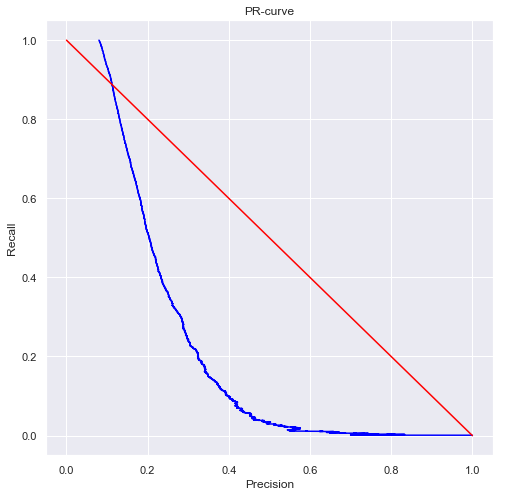

In [19]:
draw_pr_curve(precision, recall)

In [20]:
auc(recall, precision)

0.23361086062541314

In [21]:
model = LGBMClassifier()
model.fit(X_train[numerical], y_train)

LGBMClassifier()

In [22]:
preds_proba = model.predict_proba(X_test[numerical])
precision, recall, thresholds = precision_recall_curve(y_test, preds_proba[:,1])

print(precision[:10], recall[:10], thresholds[:10], sep='\n\n')

[0.07984873 0.07983447 0.07983571 0.07983695 0.07983818 0.07983942
 0.07984066 0.0798419  0.07984313 0.07984437]

[1.        0.9998059 0.9998059 0.9998059 0.9998059 0.9998059 0.9998059
 0.9998059 0.9998059 0.9998059]

[0.00856237 0.0085813  0.00863604 0.00869729 0.00872656 0.0087284
 0.00876895 0.00877624 0.00878287 0.0088137 ]


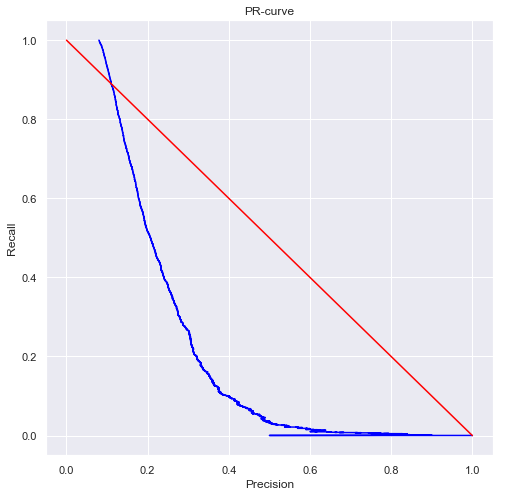

In [23]:
draw_pr_curve(precision, recall)

In [24]:
auc(recall, precision)

0.23581261749192228

Значительного отличия в качестве не наблюдаются (lgb на 0.002 хуже, чем catboost, видимо, из-за непонятного дергания внизу). Но lgb работает значительно быстрее.

Подберем оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев
* количество деревьев
* темп обучения
* оптимизируемый функционал

In [25]:
def pr_auc_score(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    
    return auc(recall, precision)

Помним, что AUC-PR мы хотим максимизировать.

In [26]:
params = {'max_depth': [1, 2, 3, 4, 5, 10, 15],
            'n_estimators': [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500, 600],
            'learning_rate': np.logspace(-2, 0, num=8),
            'loss_function': ['Logloss', 'CrossEntropy']
         }

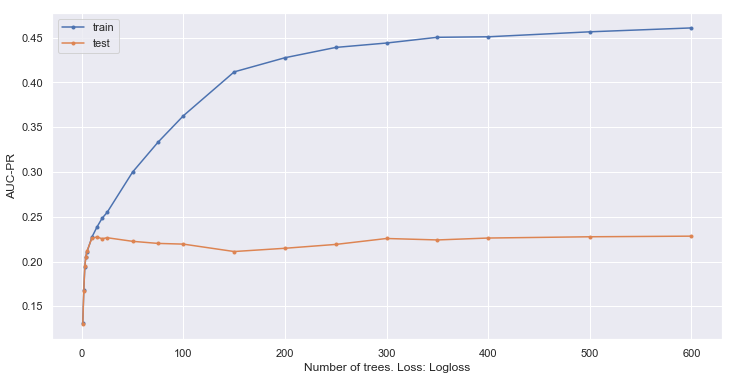

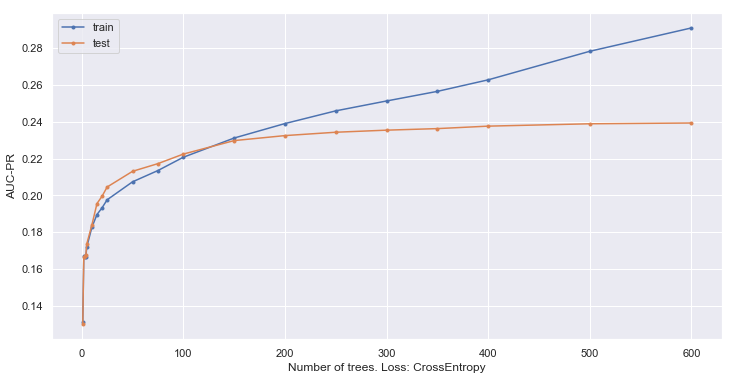

In [27]:
for metric in params['loss_function']:
    quals_train = []
    quals_test = []

    for n in params['n_estimators']:
        cbc = CatBoostClassifier(loss_function=metric, n_estimators=n, verbose=False)
        cbc.fit(X_train[numerical], y_train)
        
        q_train = pr_auc_score(  y_train, cbc.predict_proba(X_train[numerical])[:, 1]  )
        q_test = pr_auc_score(  y_test, cbc.predict_proba(X_test[numerical])[:, 1]  )
        quals_train.append(q_train)
        quals_test.append(q_test)

    plt.figure(figsize=(12, 6))
    plt.xlabel('Number of trees. Loss: ' + metric)
    plt.ylabel('AUC-PR')
    
    plt.plot(params['n_estimators'], quals_train, marker='.', label='train')
    plt.plot(params['n_estimators'], quals_test, marker='.', label='test')
    plt.legend()
    plt.show()

Лучший результат при Logloss достигается при 15, 25 или 300 деревьях. При этом при 300 деревьях для Logloss начинается плато, за которым тоже надо бы проследить.

А вот при CrossEntropy AUC-PR только растет, нужно бы еще потестировать по-хорошему, хотя при 500 намечается некоторое плато.

Дальше будем работать с LogLoss, т.к. у нас задача двухклассовой классификации.

In [28]:
params = {'max_depth': [1, 2, 3, 4, 5, 10, 15],
            'n_estimators': [15, 18, 20, 23, 25],
            'learning_rate': np.logspace(-2, 0, num=8),
            'loss_function': ['Logloss']
         }

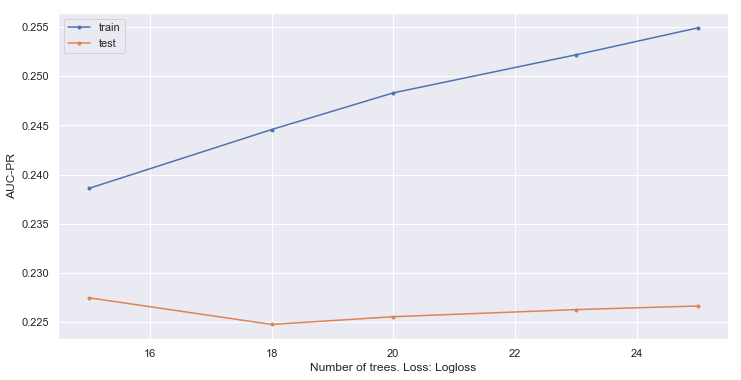

In [29]:
for metric in params['loss_function']:
    quals_train = []
    quals_test = []

    for n in params['n_estimators']:
        cbc = CatBoostClassifier(loss_function=metric, n_estimators=n, verbose=False)
        cbc.fit(X_train[numerical], y_train)
        
        q_train = pr_auc_score(  y_train, cbc.predict_proba(X_train[numerical])[:, 1]  )
        q_test = pr_auc_score(  y_test, cbc.predict_proba(X_test[numerical])[:, 1]  )
        quals_train.append(q_train)
        quals_test.append(q_test)

    plt.figure(figsize=(12, 6))
    plt.xlabel('Number of trees. Loss: ' + metric)
    plt.ylabel('AUC-PR')
    
    plt.plot(params['n_estimators'], quals_train, marker='.', label='train')
    plt.plot(params['n_estimators'], quals_test, marker='.', label='test')
    plt.legend()
    plt.show()

In [30]:
params = {'max_depth': [1, 2, 3, 4, 5, 10, 15],
            'n_estimators': [275, 290, 295, 300, 305, 310, 325],
            'learning_rate': np.logspace(-2, 0, num=8),
            'loss_function': ['Logloss']
         }

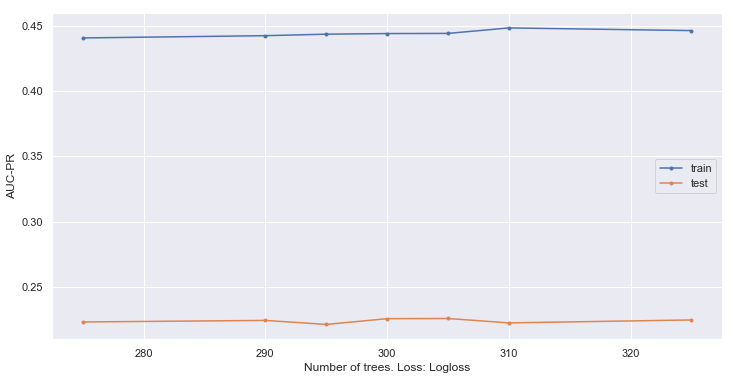

In [31]:
for metric in params['loss_function']:
    quals_train = []
    quals_test = []

    for n in params['n_estimators']:
        cbc = CatBoostClassifier(loss_function=metric, n_estimators=n, verbose=False)
        cbc.fit(X_train[numerical], y_train)
        
        q_train = pr_auc_score(  y_train, cbc.predict_proba(X_train[numerical])[:, 1]  )
        q_test = pr_auc_score(  y_test, cbc.predict_proba(X_test[numerical])[:, 1]  )
        quals_train.append(q_train)
        quals_test.append(q_test)

    plt.figure(figsize=(12, 6))
    plt.xlabel('Number of trees. Loss: ' + metric)
    plt.ylabel('AUC-PR')
    
    plt.plot(params['n_estimators'], quals_train, marker='.', label='train')
    plt.plot(params['n_estimators'], quals_test, marker='.', label='test')
    plt.legend()
    plt.show()

Итого: оптимальное число деревьев ```n_estimators=305```.
<br>Но мы еще потестируем с 15.

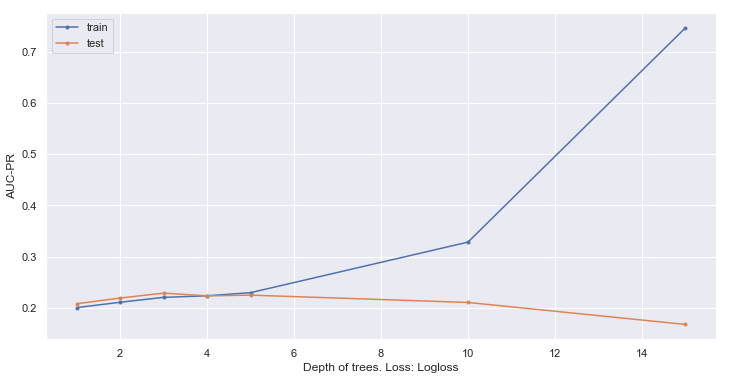

In [32]:
trees = 15

for metric in params['loss_function']:
    quals_train = []
    quals_test = []

    for d in params['max_depth']:
        cbc = CatBoostClassifier(loss_function=metric, n_estimators=trees, max_depth=d, verbose=False)
        cbc.fit(X_train[numerical], y_train)
        
        q_train = pr_auc_score(  y_train, cbc.predict_proba(X_train[numerical])[:, 1]  )
        q_test = pr_auc_score(  y_test, cbc.predict_proba(X_test[numerical])[:, 1]  )
        quals_train.append(q_train)
        quals_test.append(q_test)

    plt.figure(figsize=(12, 6))
    plt.xlabel('Depth of trees. Loss: ' + metric)
    plt.ylabel('AUC-PR')
    
    plt.plot(params['max_depth'], quals_train, marker='.', label='train')
    plt.plot(params['max_depth'], quals_test, marker='.', label='test')
    plt.legend()
    plt.show()

При 15 деревьях оптимальная глубина 3.

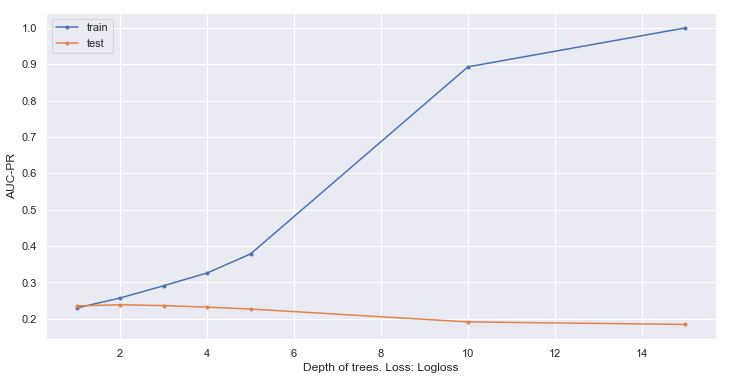

In [33]:
trees = 305

for metric in params['loss_function']:
    quals_train = []
    quals_test = []

    for d in params['max_depth']:
        cbc = CatBoostClassifier(loss_function=metric, n_estimators=trees, max_depth=d, verbose=False)
        cbc.fit(X_train[numerical], y_train)
        
        q_train = pr_auc_score(  y_train, cbc.predict_proba(X_train[numerical])[:, 1]  )
        q_test = pr_auc_score(  y_test, cbc.predict_proba(X_test[numerical])[:, 1]  )
        quals_train.append(q_train)
        quals_test.append(q_test)

    plt.figure(figsize=(12, 6))
    plt.xlabel('Depth of trees. Loss: ' + metric)
    plt.ylabel('AUC-PR')
    
    plt.plot(params['max_depth'], quals_train, marker='.', label='train')
    plt.plot(params['max_depth'], quals_test, marker='.', label='test')
    plt.legend()
    plt.show()

При 305 деревьях оптимальная глубина 1 - кажется малосодержательным, да и крайне долго считается.

Итого используем: ```n_estimators=15```, ```max_depth=3```.

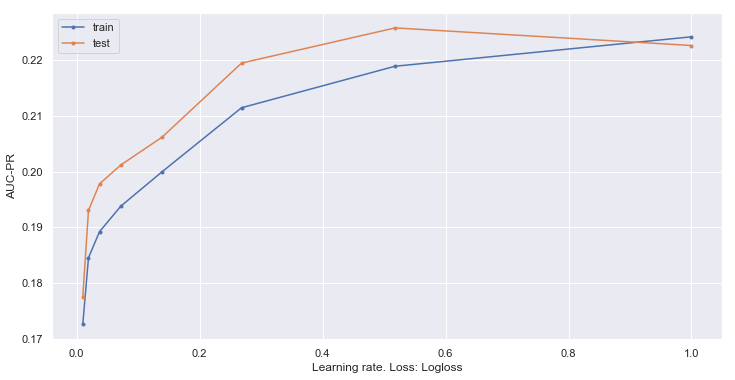

In [34]:
trees = 15
depth = 3

for metric in params['loss_function']:
    quals_train = []
    quals_test = []

    for eta in params['learning_rate']:
        cbc = CatBoostClassifier(
                                loss_function=metric,
                                n_estimators=trees,
                                max_depth=depth,
                                learning_rate=eta,
                                verbose=False
                            )
        cbc.fit(X_train[numerical], y_train)
        
        q_train = pr_auc_score(  y_train, cbc.predict_proba(X_train[numerical])[:, 1]  )
        q_test = pr_auc_score(  y_test, cbc.predict_proba(X_test[numerical])[:, 1]  )
        quals_train.append(q_train)
        quals_test.append(q_test)

    plt.figure(figsize=(12, 6))
    plt.xlabel('Learning rate. Loss: ' + metric)
    plt.ylabel('AUC-PR')
    
    plt.plot(params['learning_rate'], quals_train, marker='.', label='train')
    plt.plot(params['learning_rate'], quals_test, marker='.', label='test')
    plt.legend()
    plt.show()

In [35]:
eta = params['learning_rate'][-2]
eta

0.517947467923121

Итого: оптимальный темп обучения ```learning_rate=0.517947467923121```.

In [36]:
model = CatBoostClassifier(n_estimators=15, max_depth=3, learning_rate=0.517947467923121, verbose=False)
model.fit(X_train[numerical], y_train)

In [37]:
pred_proba = model.predict_proba(X_test[numerical])
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba[:,1])

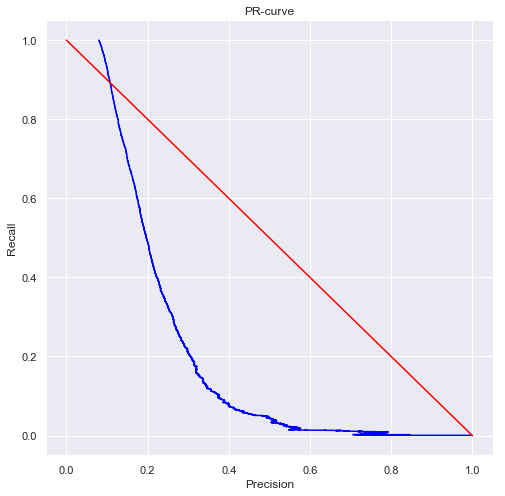

In [38]:
draw_pr_curve(precision, recall)

In [39]:
auc(recall, precision)

0.22578592101886674

Было: 
0.23361086062541314

---

Повторим весь подбор для LightGBM (у него по умолчанию стоит LogLoss):

In [40]:
params = {'max_depth': [1, 2, 3, 4, 5, 10, 15],
            'n_estimators': [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500, 600],
            'learning_rate': np.logspace(-2, 0, num=8)
         }

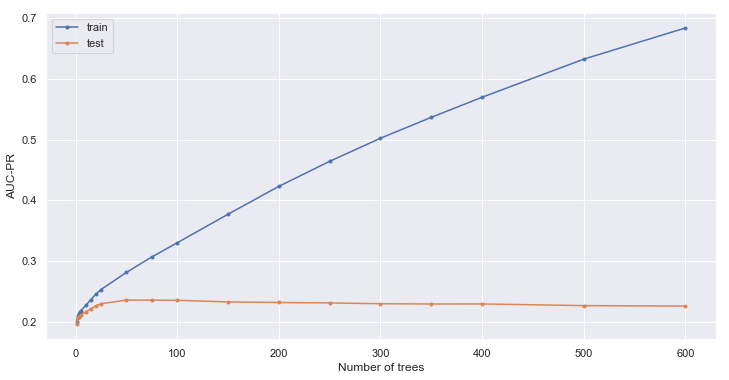

In [41]:
quals_train = []
quals_test = []

for n in params['n_estimators']:
    lgbmc = LGBMClassifier(n_estimators=n)
    lgbmc.fit(X_train[numerical], y_train)
        
    q_train = pr_auc_score(  y_train, lgbmc.predict_proba(X_train[numerical])[:, 1]  )
    q_test = pr_auc_score(  y_test, lgbmc.predict_proba(X_test[numerical])[:, 1]  )
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(12, 6))
plt.xlabel('Number of trees')
plt.ylabel('AUC-PR')
    
plt.plot(params['n_estimators'], quals_train, marker='.', label='train')
plt.plot(params['n_estimators'], quals_test, marker='.', label='test')
plt.legend()
plt.show()

In [42]:
params = {'max_depth': [1, 2, 3, 4, 5, 10, 15],
            'n_estimators': [20, 25, 30, 70, 75, 80, 95, 100, 105],
            'learning_rate': np.logspace(-2, 0, num=8),
            'loss_function': ['Logloss']
         }

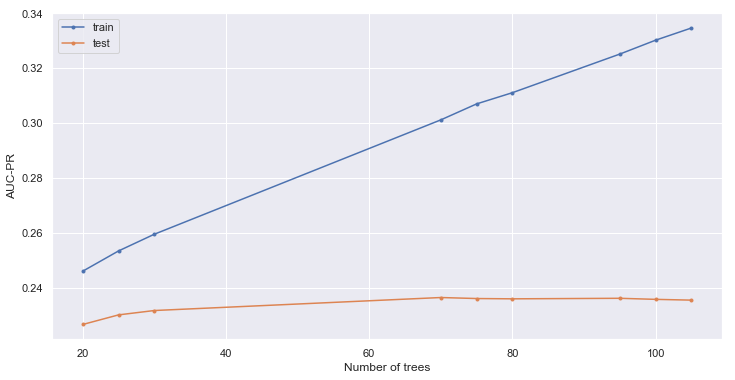

In [43]:
quals_train = []
quals_test = []

for n in params['n_estimators']:
    lgbmc = LGBMClassifier(n_estimators=n)
    lgbmc.fit(X_train[numerical], y_train)
        
    q_train = pr_auc_score(  y_train, lgbmc.predict_proba(X_train[numerical])[:, 1]  )
    q_test = pr_auc_score(  y_test, lgbmc.predict_proba(X_test[numerical])[:, 1]  )
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(12, 6))
plt.xlabel('Number of trees')
plt.ylabel('AUC-PR')
    
plt.plot(params['n_estimators'], quals_train, marker='.', label='train')
plt.plot(params['n_estimators'], quals_test, marker='.', label='test')
plt.legend()
plt.show()

Итого: оптимальное число деревьев ```n_estimators=70```.

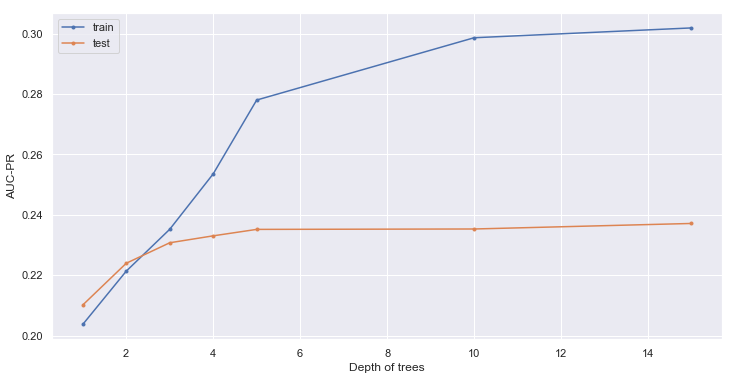

In [44]:
trees = 70

quals_train = []
quals_test = []

for d in params['max_depth']:
    lgbmc = LGBMClassifier(n_estimators=trees, max_depth=d)
    lgbmc.fit(X_train[numerical], y_train)
        
    q_train = pr_auc_score(  y_train, lgbmc.predict_proba(X_train[numerical])[:, 1]  )
    q_test = pr_auc_score(  y_test, lgbmc.predict_proba(X_test[numerical])[:, 1]  )
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(12, 6))
plt.xlabel('Depth of trees')
plt.ylabel('AUC-PR')
    
plt.plot(params['max_depth'], quals_train, marker='.', label='train')
plt.plot(params['max_depth'], quals_test, marker='.', label='test')
plt.legend()
plt.show()

Итого: оптимальное глубина деревьев ```max_depth=5```.

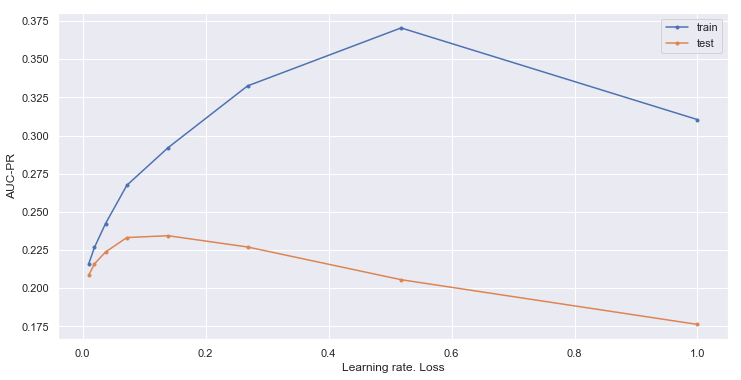

In [45]:
trees = 70
depth = 5
quals_train = []
quals_test = []

for eta in params['learning_rate']:
    lgbmc = LGBMClassifier(n_estimators=trees, max_depth=depth, learning_rate=eta)
    lgbmc.fit(X_train[numerical], y_train)
        
    q_train = pr_auc_score(  y_train, lgbmc.predict_proba(X_train[numerical])[:, 1]  )
    q_test = pr_auc_score(  y_test, lgbmc.predict_proba(X_test[numerical])[:, 1]  )
    quals_train.append(q_train)
    quals_test.append(q_test)

plt.figure(figsize=(12, 6))
plt.xlabel('Learning rate. Loss')
plt.ylabel('AUC-PR')
    
plt.plot(params['learning_rate'], quals_train, marker='.', label='train')
plt.plot(params['learning_rate'], quals_test, marker='.', label='test')
plt.legend()
plt.show()

In [46]:
eta = params['learning_rate'][-2]
eta

0.517947467923121

Итого: оптимальный темп обучения ```learning_rate=0.517947467923121```.

In [47]:
model = LGBMClassifier(n_estimators=70, max_depth=5, learning_rate=0.517947467923121)
model.fit(X_train[numerical], y_train)

LGBMClassifier(learning_rate=0.517947467923121, max_depth=5, n_estimators=70)

In [48]:
preds_proba = model.predict_proba(X_test[numerical])
precision, recall, thresholds = precision_recall_curve(y_test, preds_proba[:,1])

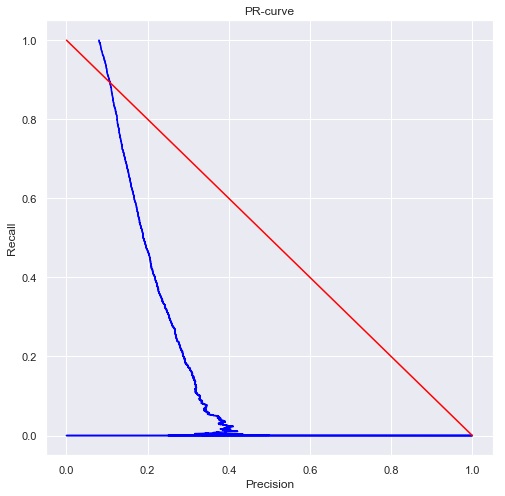

In [49]:
draw_pr_curve(precision, recall)

In [50]:
auc(recall, precision)

0.20562433820384193

Было: 0.23581261749192228
<br>У CatBoost после подбора: 0.22578592101886674

**Вывод**:
<br>*CatBoost* обходится небольшим числом деревьев небольшой глубины, но learning rate достаточно большой, что как раз и компенсирует небольшое количество деревьев.
<br>*LightGBM* требует большого числа деревьев и несколько большей глубины, learning rate попрежнему солидный. Каждое отдельное дерево учится быстрее и менее увлекательно, чем в CatBoosst.

---

Добавим категориальные признаки к вещественным следующими способами:

* как OHE признаки
* как счетчики со сглаживанием

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [52]:
column_ohe_transformer = ColumnTransformer([
                                            ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
                                            ('scaling', StandardScaler(), numerical)
                                        ])

X_train_ohe = column_ohe_transformer.fit_transform(X_train)
X_test_ohe = column_ohe_transformer.transform(X_test)

X_train_ohe.shape

(150679, 289)

In [53]:
cbc = CatBoostClassifier(loss_function='Logloss',
                        n_estimators=15,
                        depth=3,
                        learning_rate=0.517947467923121,
                        verbose=False)
cbc.fit(X_train_ohe, y_train)

In [54]:
q_train = pr_auc_score(  y_train, cbc.predict_proba(X_train_ohe)[:, 1]  )
q_test = pr_auc_score(  y_test, cbc.predict_proba(X_test_ohe)[:, 1]  )

print(q_train, q_test)

0.22557642106419099 0.23219087991304715


In [55]:
cbc = CatBoostClassifier(verbose=False)
cbc.fit(X_train_ohe, y_train)

In [56]:
q_train = pr_auc_score(  y_train, cbc.predict_proba(X_train_ohe)[:, 1]  )
q_test = pr_auc_score(  y_test, cbc.predict_proba(X_test_ohe)[:, 1]  )

print(q_train, q_test)

0.48411500156762743 0.24042806035691758


За счет того, что модель стала сама по себе сложнее, мы наблюдаем, что при старых параметрах у нас недообучение, а при стандартных оно обучается и все хорошо.

In [57]:
lgbmc = LGBMClassifier(n_estimators=70, max_depth=5, learning_rate=0.517947467923121)
lgbmc.fit(X_train_ohe, y_train)

LGBMClassifier(learning_rate=0.517947467923121, max_depth=5, n_estimators=70)

In [58]:
q_train = pr_auc_score(y_train, lgbmc.predict_proba(X_train_ohe)[:, 1])
q_test = pr_auc_score(y_test, lgbmc.predict_proba(X_test_ohe)[:, 1])

print(q_train, q_test)

0.38342578653147985 0.20486737228688984


In [59]:
lgbmc = LGBMClassifier()
lgbmc.fit(X_train_ohe, y_train)

LGBMClassifier()

In [60]:
q_train = pr_auc_score(y_train, lgbmc.predict_proba(X_train_ohe)[:, 1])
q_test = pr_auc_score(y_test, lgbmc.predict_proba(X_test_ohe)[:, 1])

print(q_train, q_test)

0.34501355310700166 0.24161524734410256


Тоже самое, но уже заметно лучше.

Теперь попробуем счетчики:

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

In [62]:
class SmoothCounterEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, sigma, c, prior=None):
        self.stats = dict()
        self.sigma = sigma
        self.c = c
        self.prior = prior
    
    def fit(self, X, y):
        if self.prior is None:
            self.prior = y.mean()
            
        for col in X.columns:
            cur_stats = (X[col][y == 1].value_counts() + self.c * self.prior) / \
                            (X[col].value_counts() + self.c) + \
                                np.random.normal(0, self.sigma, size=X[col].nunique())
            self.stats[col] = cur_stats.to_dict()
        
        return self
        
    def columns_transform(self, x, columns):
        x_new = np.zeros(x.shape, dtype=float)
        it = 0
        for col in columns:
            x_new[it] = float(self.stats[col].get(x[col], 0))
            it += 1
            
        return x_new

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.apply(self.columns_transform, axis=1, columns=X.columns, result_type='expand')
        
        return X_copy

In [63]:
column_counter_transformer = ColumnTransformer([
                                                ('counter', SmoothCounterEncoding(0.05, 10), categorical),
                                                ('scaling', StandardScaler(), numerical)
                                            ])

In [64]:
X_train_cnt = column_counter_transformer.fit_transform(X_train, y_train)
X_test_cnt = column_counter_transformer.transform(X_test)

X_train_cnt.shape

(150679, 120)

Наблюдаем разницу в shape'ах между X_train_ohe (почти 300) и X_train_cnt.

In [65]:
cbc = CatBoostClassifier(loss_function='Logloss',
                            n_estimators=15,
                            depth=3,
                            learning_rate=0.517947467923121,
                            verbose=False)
cbc.fit(X_train_cnt, y_train)

In [66]:
q_train = pr_auc_score(y_train, cbc.predict_proba(X_train_cnt)[:, 1])
q_test = pr_auc_score(y_test, cbc.predict_proba(X_test_cnt)[:, 1])

print(q_train, q_test)

0.22684688581011425 0.23037730923709376


In [67]:
cbc = CatBoostClassifier(verbose=False)
cbc.fit(X_train_ohe, y_train)

In [68]:
cbc = CatBoostClassifier(verbose=False)
cbc.fit(X_train_cnt, y_train)

In [69]:
q_train = pr_auc_score(  y_train, cbc.predict_proba(X_train_cnt)[:, 1]  )
q_test = pr_auc_score(  y_test, cbc.predict_proba(X_test_cnt)[:, 1]  )

print(q_train, q_test)

0.4884767885669146 0.24366939374092939


За счет того, что модель стала сама по себе сложнее, мы наблюдаем, что при старых параметрах у нас недообучение, а при стандартных оно обучается и все хорошо.

Улучшения как-то не наблюдается.

In [70]:
lgbmc = LGBMClassifier(n_estimators=70, max_depth=5, learning_rate=0.517947467923121)
lgbmc.fit(X_train_cnt, y_train)

LGBMClassifier(learning_rate=0.517947467923121, max_depth=5, n_estimators=70)

In [71]:
q_train = pr_auc_score(y_train, lgbmc.predict_proba(X_train_cnt)[:, 1])
q_test = pr_auc_score(y_test, lgbmc.predict_proba(X_test_cnt)[:, 1])

print(q_train, q_test)

0.38839180783902694 0.200372784081422


In [72]:
lgbmc = LGBMClassifier()
lgbmc.fit(X_train_cnt, y_train)

LGBMClassifier()

In [73]:
q_train = pr_auc_score(y_train, lgbmc.predict_proba(X_train_cnt)[:, 1])
q_test = pr_auc_score(y_test, lgbmc.predict_proba(X_test_cnt)[:, 1])

print(q_train, q_test)

0.3398457286249838 0.24575143426621038


И здесь тоже улучшения не наблюдается (скорее, ухудшение). Но зато время обучения заметно сократилось.

Попробуем встроенные методы обработки категориальных признаков (правда придется использовать только categorical_str, ибо CatBoost не поддерживает float64 категориальные признаки):

In [74]:
cbc = CatBoostClassifier(verbose=False)
cbc.fit(X_train, y_train, categorical_str)

In [75]:
q_train = pr_auc_score(y_train, cbc.predict_proba(X_train)[:, 1])
q_test = pr_auc_score(y_test, cbc.predict_proba(X_test)[:, 1])

print(q_train, q_test)

0.43998044434522343 0.24536428431064164


Встроенный в LGBM обработчик категориальных признаков может также работать только с преобразованными к int64 признаками. Но здесь мы можем ему помочь:

In [76]:
from sklearn.preprocessing import OrdinalEncoder

In [77]:
column_transformer = ColumnTransformer([
                                        ('ordinal', OrdinalEncoder(), categorical),
                                        ('scaling', StandardScaler(), numerical)
                                    ])

In [78]:
column_transformer.fit(X)

X_train_ord = column_transformer.transform(X_train)
X_test_ord = column_transformer.transform(X_test)

X_train_ord.shape

(150679, 120)

In [79]:
cat_indecies = []
it = 0
for col in X.columns:
    if col in categorical:
        cat_indecies.append(it)
    it += 1
    
np.array(cat_indecies)

array([  0,   1,   2,   3,   9,  10,  11,  12,  13,  20,  21,  22,  23,
        24,  25,  26,  28,  29,  30,  32,  33,  34,  35,  36,  37,  38,
        84,  85,  87,  88,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114])

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
lgbmc = LGBMClassifier()
lgbmc.fit(X_train_ord, y_train, categorical_feature=cat_indecies)

LGBMClassifier()

In [82]:
q_train = pr_auc_score(  y_train, lgbmc.predict_proba(X_train_ord)[:, 1]  )
q_test = pr_auc_score(  y_test, lgbmc.predict_proba(X_test_ord)[:, 1]  )

print(q_train, q_test)

0.33865772298013586 0.22633270439433367


**Вывод**: Счетчики жгут лучше всего для LGBM, а вот катбуст хорошо себя чувствует со своей собственной кодировкой (хотя с счетчиками чуть лучше жжет).

---

Реализуем блендинг подобранных в предыдущем пункте моделей (CatBoost со своим собственным отбором и LGBM со счетчиками):

In [83]:
cbc = CatBoostClassifier(verbose=False)
cbc.fit(X_train, y_train, categorical_str)

In [84]:
lgbmc = LGBMClassifier()
lgbmc.fit(X_train_cnt, y_train)

LGBMClassifier()

In [85]:
def select_weights(y_true, y_pred_1, y_pred_2):
    grid = np.linspace(0, 1, 1000)
    metric = []
    
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append(  [pr_auc_score(y_true, y_a), w_0, w_1]  )
        
    return metric

In [86]:
auc_pr_blending_train, w0, w1 = max(select_weights(
                                                    y_train, 
                                                    cbc.predict_proba(X_train)[:, 1], 
                                                    lgbmc.predict_proba(X_train_cnt)[:, 1]
                                                ), 
                                    key=lambda x: x[0])

In [87]:
auc_pr_blending_train

0.43998044434522343

In [88]:
pr_auc_score(
            y_test, w0*cbc.predict_proba(X_test)[:, 1] + \
            w1*lgbmc.predict_proba(X_test_cnt)[:, 1]
            )

0.24536428431064164

**Вывод**: блендинг работает, мы улучшили наш результат.

---

Ранее мы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируем важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot:

In [89]:
cbc = CatBoostClassifier(loss_function='Logloss',
                        n_estimators=15,
                        depth=3,
                        learning_rate=0.517947467923121,
                        verbose=False)
cbc.fit(X_train[numerical], y_train)

In [90]:
feature_importance = list(zip(  cbc.get_feature_importance(), numerical  ))

In [91]:
feature_importance.sort()
feature_importance = np.array([*feature_importance])
feature_importance

array([['0.0', 'AMT_INCOME_TOTAL'],
       ['0.0', 'AMT_REQ_CREDIT_BUREAU_DAY'],
       ['0.0', 'AMT_REQ_CREDIT_BUREAU_MON'],
       ['0.0', 'AMT_REQ_CREDIT_BUREAU_WEEK'],
       ['0.0', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
       ['0.0', 'APARTMENTS_MEDI'],
       ['0.0', 'APARTMENTS_MODE'],
       ['0.0', 'BASEMENTAREA_AVG'],
       ['0.0', 'BASEMENTAREA_MEDI'],
       ['0.0', 'BASEMENTAREA_MODE'],
       ['0.0', 'CNT_CHILDREN'],
       ['0.0', 'CNT_FAM_MEMBERS'],
       ['0.0', 'COMMONAREA_AVG'],
       ['0.0', 'COMMONAREA_MEDI'],
       ['0.0', 'DAYS_REGISTRATION'],
       ['0.0', 'ELEVATORS_AVG'],
       ['0.0', 'ELEVATORS_MEDI'],
       ['0.0', 'ELEVATORS_MODE'],
       ['0.0', 'ENTRANCES_AVG'],
       ['0.0', 'ENTRANCES_MEDI'],
       ['0.0', 'ENTRANCES_MODE'],
       ['0.0', 'FLOORSMAX_AVG'],
       ['0.0', 'FLOORSMAX_MEDI'],
       ['0.0', 'FLOORSMIN_AVG'],
       ['0.0', 'FLOORSMIN_MEDI'],
       ['0.0', 'FLOORSMIN_MODE'],
       ['0.0', 'LANDAREA_AVG'],
       ['0.0', 'LANDAREA_ME

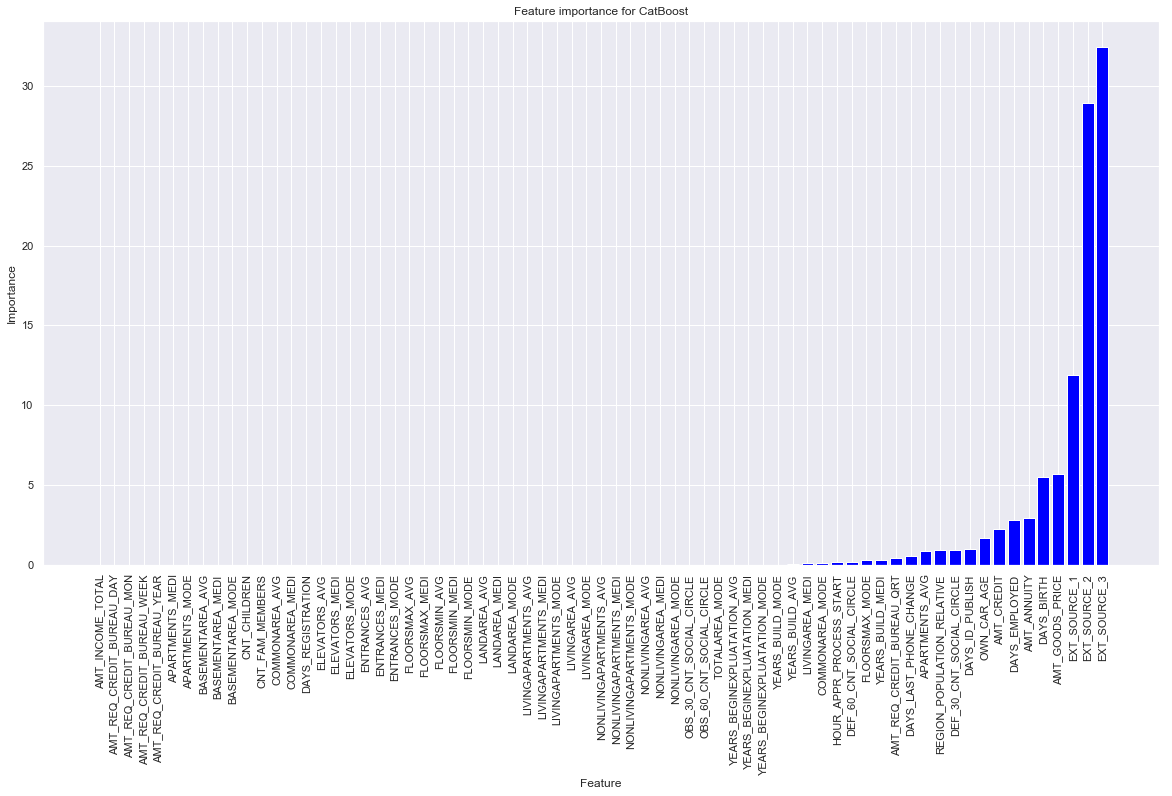

In [92]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importance for CatBoost")

plt.bar(x=feature_importance[:,1], height=list(map(float, feature_importance[:,0])), color='blue')
plt.xticks(rotation=90)
plt.show()

In [93]:
lgbmc = LGBMClassifier(n_estimators=70, max_depth=5, learning_rate=0.517947467923121)
lgbmc.fit(X_train[numerical], y_train)

LGBMClassifier(learning_rate=0.517947467923121, max_depth=5, n_estimators=70)

In [94]:
feature_importance = list(zip(  lgbmc.feature_importances_, numerical  ))

In [95]:
feature_importance.sort()
feature_importance = np.array([*feature_importance])
feature_importance

array([['1', 'AMT_REQ_CREDIT_BUREAU_DAY'],
       ['2', 'FLOORSMAX_MEDI'],
       ['2', 'FLOORSMIN_MEDI'],
       ['3', 'CNT_CHILDREN'],
       ['3', 'ELEVATORS_MEDI'],
       ['3', 'YEARS_BUILD_MEDI'],
       ['4', 'ELEVATORS_AVG'],
       ['4', 'ELEVATORS_MODE'],
       ['4', 'FLOORSMIN_AVG'],
       ['4', 'NONLIVINGAPARTMENTS_MODE'],
       ['5', 'AMT_REQ_CREDIT_BUREAU_WEEK'],
       ['5', 'ENTRANCES_MEDI'],
       ['5', 'FLOORSMAX_MODE'],
       ['5', 'FLOORSMIN_MODE'],
       ['6', 'ENTRANCES_MODE'],
       ['7', 'APARTMENTS_MEDI'],
       ['7', 'NONLIVINGAPARTMENTS_MEDI'],
       ['7', 'YEARS_BEGINEXPLUATATION_MEDI'],
       ['8', 'BASEMENTAREA_MEDI'],
       ['8', 'DEF_30_CNT_SOCIAL_CIRCLE'],
       ['8', 'DEF_60_CNT_SOCIAL_CIRCLE'],
       ['8', 'NONLIVINGAPARTMENTS_AVG'],
       ['9', 'LIVINGAPARTMENTS_AVG'],
       ['9', 'OBS_60_CNT_SOCIAL_CIRCLE'],
       ['10', 'AMT_REQ_CREDIT_BUREAU_MON'],
       ['10', 'AMT_REQ_CREDIT_BUREAU_QRT'],
       ['10', 'LIVINGAPARTMENTS_MEDI'],


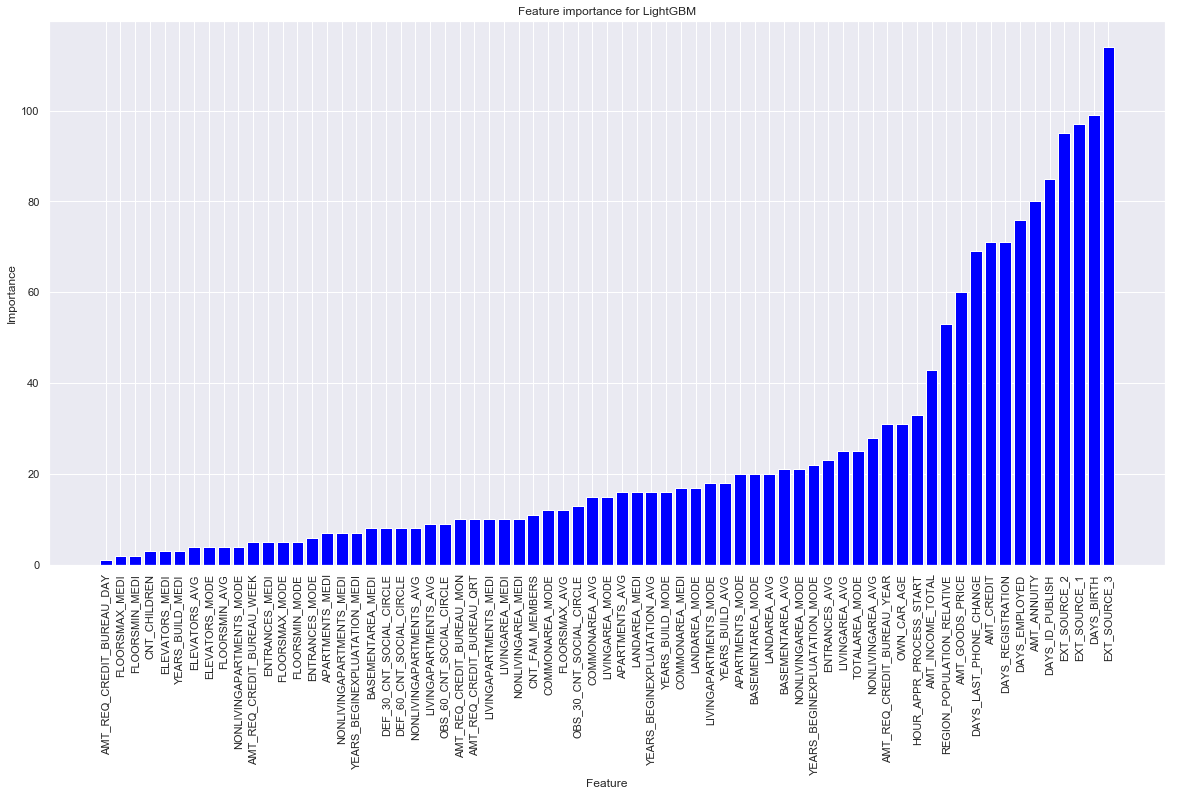

In [96]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importance for LightGBM")

plt.bar(x=feature_importance[:,1], height=list(map(float, feature_importance[:,0])), color='blue')
plt.xticks(rotation=90)
plt.show()

Для каждого из двух алгоритмов удалим неважные признаки (обычно по bar-plot хорошо видно порог, с которого начинается "хвост" менее важных признаков) и обучим модель с теми же параметрами на получившихся данных. Посмотрим на результат:

In [97]:
pr_auc_score(y_test, cbc.predict_proba(X_test[numerical])[:, 1])

0.22578592101886674

In [98]:
new_features = feature_importance[feature_importance[:,0].astype('float') >= 1][:,1]

In [99]:
cbc = CatBoostClassifier(loss_function='Logloss',
                        n_estimators=15,
                        depth=3,
                        learning_rate=0.517947467923121,
                        verbose=False)
cbc.fit(X_train[new_features], y_train)

In [100]:
pr_auc_score(y_test, cbc.predict_proba(X_test[new_features])[:, 1])

0.2250476685817706

Разницы нет. Well played.

In [101]:
pr_auc_score(y_test, lgbmc.predict_proba(X_test[numerical])[:, 1])

0.20562433820384193

In [102]:
new_features = feature_importance[feature_importance[:,0].astype('int') > 15][:,1]

In [103]:
lgbmc = LGBMClassifier(n_estimators=70, max_depth=5, learning_rate=0.517947467923121)
lgbmc.fit(X_train[new_features], y_train)

LGBMClassifier(learning_rate=0.517947467923121, max_depth=5, n_estimators=70)

In [104]:
pr_auc_score(y_test, lgbmc.predict_proba(X_test[new_features])[:, 1])

0.19631038739100398

А вот здесь разница заметна в лучшую сторону (чего-то LGBMC() сегодня нас радует больше).